# Performance assessment


## Determine binary classification statistics 

For the v3 site filter, vs:
- phase 2 accessibility map
- permissive (100% pass, 0 fail)

based on:
- Mendelian error in all crosses (autosomes)
- male het calls (`n_male_het`, `all_males_called`) will be used instead of `mendel_error`

In [1]:
# Imports:
import gcsfs
import zarr
import dask.array as da
from dask.distributed import Client
import pandas as pd
import numpy as np
import numba
from pathlib import Path
#
import ag3
import ag2

In [2]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client

In [3]:
#cluster = KubeCluster()
#cluster.adapt(minimum=0, maximum=n_workers)
cluster = KubeCluster(n_workers=20)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.10:39843
distributed.scheduler - INFO -   dashboard at:                     :8787


In [4]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-9e492570-07c0-11eb-8312-faca4548bb18
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.35.63.10:39843 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# Settings:
cross_family_ids = ['18-5', '29-2', '36-9', '37-3', '42-4', '45-1', '46-9', '47-6', '73-2', '78-2', '80-2', 'B5', 'K2', 'K4', 'K6']
chrom_arms = ['2R', '2L', '3R', '3L']

In [6]:
eval_family_ids = ['B5', 'K6', '73-2', '45-1', '37-3']

In [7]:
cross_family_ids

['18-5',
 '29-2',
 '36-9',
 '37-3',
 '42-4',
 '45-1',
 '46-9',
 '47-6',
 '73-2',
 '78-2',
 '80-2',
 'B5',
 'K2',
 'K4',
 'K6']

## Determine which crosses stats (inc. Mendelian error) are predicted by each site filter

Populate the confusion matrix, such that:
- If the crosses stats imply that a position is accessible ("good") and the site filter also says it passes, then mark the prediction as a `True Positive` (`TP`)
- If the crosses stats imply that a position is accessible ("good") but the site filter says it fails, then mark the prediction as a `False Negative` (`FN`)
- If the crosses stats imply that a position is inaccessible ("bad") and the site filter also says it fails, then mark the prediction as a `True Negative` (`TN`)
- If the crosses stats imply that a position is inaccessible ("bad") but the site filter says it passes, then mark the prediction as a `False Positive` (`FP`)
- If the crosses stats cannot determine whether a position is "good" or "bad" (e.g. there were no male het calls on the X chromosome, but not all samples were called), then mark the prediction result as undetermined and exclude from subsequent stats.

In [8]:
@numba.njit
def cross_tab_values(eval_arr, test_arr):
    
    out = np.zeros((2, 2))
    
    # TN FP
    # FN TP
    
    # eval arr has 
    for i in range(eval_arr.shape[0]):
        if eval_arr[i] == -1:
            continue
        
        if test_arr[i]:
            out[eval_arr[i], 1] += 1
        else:
            out[eval_arr[i], 0] += 1
    
    return out.reshape((1, 2, 2))

In [9]:
ag3_release_data = ag3.release_data()

def load_phase3_accessibility(chrom):
    return ag3_release_data.load_mask(chrom, mask_id='gamb_colu')

In [10]:
ag2_release_data = ag2.release_data()

def load_phase2_accessibility(chrom):
    
    phase2_is_accessible = ag2_release_data.load_is_accessible(chrom)
    filter_n = ag2_release_data.load_filter_n(chrom)
    phase2_is_accessible_nonN = da.compress(~filter_n, phase2_is_accessible, axis=0)

    # Compute chunk sizes avoids this error when concatenating arrays: ValueError: Arrays chunk sizes are unknown: (nan,)
    phase2_is_accessible_nonN.compute_chunk_sizes() 
    return phase2_is_accessible_nonN

In [11]:
def load_ground_truth(chrom, xid):
    
    if chrom == "X":
        raise ValueError("X Not supported as hemizygous")
    
    me = ag3_release_data.load_crosses(chrom, xid, 'mendel_error')
    called = ag3_release_data.load_crosses(chrom, xid, 'n_samples_called')

    training_negative = ag3_release_data.load_mask(chrom, mask_id='gamb_colu', field='training_negative')
    training_positive = ag3_release_data.load_mask(chrom, mask_id='gamb_colu', field='training_positive')
    training_mask = training_negative | training_positive

    # Mark training sites as undetermined (-1)
    return da.where(training_mask, -1, da.where(me > 0, 0, da.where(called == da.max(called), 1, -1)))


In [12]:
def calculate_metrics_of_interest(true_neg, false_pos, false_neg, true_pos):
    
    r = {}
    r["tpr"] = true_pos / (true_pos + false_neg)
    r["fpr"] = false_pos / (false_pos + true_neg)
    r["fdr"] = false_pos / (true_pos + false_pos)
    r["tnr"] = 1 - (false_pos / (false_pos + true_neg))
    r["youden"] = r["tpr"] + r["tnr"] - 1
    
    return pd.Series(r)

In [13]:
chrom_arms

['2R', '2L', '3R', '3L']

In [14]:
cross_family_ids

['18-5',
 '29-2',
 '36-9',
 '37-3',
 '42-4',
 '45-1',
 '46-9',
 '47-6',
 '73-2',
 '78-2',
 '80-2',
 'B5',
 'K2',
 'K4',
 'K6']

In [15]:
desired_chunks = (500_000,)

In [16]:
%%time
data_holder = {}

for chrom_arm in chrom_arms:
        
    # varies by chrom only, but need to be chunked depending on ground_truth
    alternative_calls = {
        "phase2": load_phase2_accessibility(chrom_arm).rechunk(desired_chunks),
        "phase3": load_phase3_accessibility(chrom_arm).rechunk(desired_chunks)
    }
    
    alternative_calls["r100"] = da.ones(alternative_calls["phase2"].shape[0], dtype=np.bool, chunks=desired_chunks)
    
    chunks = ((1, ) * alternative_calls["phase2"].numblocks[0], 2, 2)
    x = da.map_blocks(
        cross_tab_values, 
        alternative_calls["phase2"].astype("int"), 
        alternative_calls["phase3"], 
        chunks=chunks,
        dtype=np.int32,
        new_axis=[1, 2]).sum(axis=0).compute()

    for cross_id in cross_family_ids:
        
        print("processing", chrom_arm, cross_id)

        # varies by cross and chrom
        ground_truth = load_ground_truth(chrom_arm, cross_id).rechunk(desired_chunks)


        for key, eval_data in alternative_calls.items():
            
            if (key, chrom_arm, cross_id) in data_holder:
                print("skipping", (key, chrom_arm, cross_id))
                continue

            chunks = ((1, ) * ground_truth.numblocks[0], 2, 2)
            q = da.map_blocks(
                cross_tab_values, 
                ground_truth, 
                eval_data, 
                chunks=chunks, 
                dtype=np.int32, 
                new_axis=[1, 2]).sum(axis=0)

            (tn, fp), (fn, tp) = q.compute()

            # frac accessible is simply TPs + FPs. / all
            #res["frac_accessible"] = eval_data.mean().compute()

            data_holder[key, chrom_arm, cross_id] = pd.Series(
                [tn, fp, fn, tp], dtype=np.int32, index=["TN", "FP", "FN", "TP"])
# Wall time: 39min 24s

distributed.scheduler - INFO - Register tcp://10.32.253.3:44907
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.253.3:44907
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.229.2:44703
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.229.2:44703
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.14.2:44049
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.14.2:44049
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.5.2:44415
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.5.2:44415
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.226.2:42249
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.226.2:42249
distributed.core - 

processing 2R 18-5


distributed.scheduler - INFO - Register tcp://10.33.17.2:45399
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.17.2:45399
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.224.2:45985
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.224.2:45985
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.250.2:42049
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.250.2:42049
distributed.core - INFO - Starting established connection


processing 2R 29-2
processing 2R 36-9
processing 2R 37-3
processing 2R 42-4
processing 2R 45-1
processing 2R 46-9
processing 2R 47-6
processing 2R 73-2
processing 2R 78-2
processing 2R 80-2
processing 2R B5
processing 2R K2
processing 2R K4
processing 2R K6
processing 2L 18-5
processing 2L 29-2
processing 2L 36-9
processing 2L 37-3
processing 2L 42-4
processing 2L 45-1
processing 2L 46-9
processing 2L 47-6
processing 2L 73-2
processing 2L 78-2
processing 2L 80-2
processing 2L B5
processing 2L K2
processing 2L K4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 2L K6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R 18-5
processing 3R 29-2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R 36-9


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R 37-3


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R 42-4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R 45-1
processing 3R 46-9
processing 3R 47-6
processing 3R 73-2
processing 3R 78-2
processing 3R 80-2


distributed.utils_perf - INFO - full garbage collection released 11.08 MB from 668 reference cycles (threshold: 10.00 MB)


processing 3R B5


distributed.utils_perf - INFO - full garbage collection released 11.08 MB from 413 reference cycles (threshold: 10.00 MB)


processing 3R K2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R K4


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3R K6


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 18-5


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 29-2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 36-9


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 37-3


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 42-4


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 45-1


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 46-9


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 47-6


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


processing 3L 73-2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3L 78-2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3L 80-2


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3L B5


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


processing 3L K2
processing 3L K4
processing 3L K6
CPU times: user 12min 46s, sys: 37.1 s, total: 13min 23s
Wall time: 18min 44s


In [17]:
df = pd.concat(data_holder, axis=0, sort=False, names=["description", "chrom", "cross_id", "metric"])
df.name = "value"

In [18]:
df

description  chrom  cross_id  metric
phase2       2R     18-5      TN          506109
                              FP          169050
                              FN        13561823
                              TP        38985526
phase3       2R     18-5      TN          532775
                                          ...   
             3L     K6        TP        28522274
r100         3L     K6        TN               0
                              FP          273090
                              FN               0
                              TP        35983387
Name: value, Length: 720, dtype: int32

In [19]:
output = pd.pivot_table(
    pd.DataFrame(df).reset_index(level="metric"), 
    index=["description", "chrom", "cross_id"], 
    columns="metric", 
    values="value")

In [20]:
output_all_chroms = output.groupby(level=[0, 2]).agg(np.sum)
output_all_chroms

metric                      FN       FP       TN         TP
description cross_id                                       
phase2      18-5      52462749   530938  1846531  123336581
            29-2      51168424   714464  2066324  123078854
            36-9      53944629   208023  1792916  123777030
            37-3      54999285   247028  1749469  123748305
            42-4      55349482   119417  1148603  124022245
            45-1      54051247   196013  1474033  123837019
            46-9      52787669   283228  1913174  123590590
            47-6      53913301   231437  1497438  123805832
            73-2      53611476   156703  1539479  123889152
            78-2      54387076   157935  1296058  123921582
            80-2      53629149   276881  1456303  123812885
            B5        54925162    99630  1330501  123880988
            K2        54931595    96047  1476857  123874852
            K4        55280576    75907  1245637  123931645
            K6        54522203    73390  1272897  123897320
phase3      18-5      31085474   470500  1906969  144713856
            29-2      29840246   657787  2123001  144407032
            36-9      32432596   116141  1884798  145289063
            37-3      33481368   150540  1845957  145266222
            42-4      33958846    49268  1218752  145412881
            45-1      32608471   100161  1569885  145279795
            46-9      31268626   178092  2018310  145109633
            47-6      32474572   137979  1590896  145244561
            73-2      32107427    71830  1624352  145393201
            78-2      32975058    64396  1389597  145333600
            80-2      32205907   175213  1557971  145236127
            B5        33540645    87827  1342304  145265505
            K2        33504134    79692  1493212  145302313
            K4        33861174    56000  1265544  145351047
            K6        33074026    53932  1292355  145345497
r100        18-5             0  2377469        0  175799330
            29-2             0  2780788        0  174247278
            36-9             0  2000939        0  177721659
            37-3             0  1996497        0  178747590
            42-4             0  1268020        0  179371727
            45-1             0  1670046        0  177888266
            46-9             0  2196402        0  176378259
            47-6             0  1728875        0  177719133
            73-2             0  1696182        0  177500628
            78-2             0  1453993        0  178308658
            80-2             0  1733184        0  177442034
            B5               0  1430131        0  178806150
            K2               0  1572904        0  178806447
            K4               0  1321544        0  179212221
            K6               0  1346287        0  178419523

In [21]:
output_summary = output.apply(lambda y: calculate_metrics_of_interest(*y), axis=1)

In [22]:
output_all_chroms_summary = output_all_chroms.apply(lambda y: calculate_metrics_of_interest(*y), axis=1)
output_all_chroms_summary

tpr       fpr       fdr       tnr    youden
description cross_id                                                  
phase2      18-5      0.985249  0.010019  0.004286  0.989981  0.975230
            29-2      0.983489  0.013771  0.005771  0.986229  0.969718
            36-9      0.985722  0.003841  0.001678  0.996159  0.981880
            37-3      0.986060  0.004471  0.001992  0.995529  0.981588
            42-4      0.990824  0.002153  0.000962  0.997847  0.988671
            45-1      0.988237  0.003613  0.001580  0.996387  0.984624
            46-9      0.984756  0.005337  0.002286  0.994663  0.979419
            47-6      0.988049  0.004274  0.001866  0.995726  0.983775
            73-2      0.987726  0.002914  0.001263  0.997086  0.984812
            78-2      0.989650  0.002895  0.001273  0.997105  0.986754
            80-2      0.988375  0.005136  0.002231  0.994864  0.983238
            B5        0.989374  0.001811  0.000804  0.998189  0.987563
            K2        0.988218  0.001745  0.000775  0.998255  0.986473
            K4        0.990049  0.001371  0.000612  0.998629  0.988678
            K6        0.989831  0.001344  0.000592  0.998656  0.988486
phase3      18-5      0.986994  0.014910  0.003241  0.985090  0.972084
            29-2      0.985511  0.021568  0.004534  0.978432  0.963943
            36-9      0.987193  0.003568  0.000799  0.996432  0.983625
            37-3      0.987452  0.004476  0.001035  0.995524  0.982976
            42-4      0.991688  0.001449  0.000339  0.998551  0.990240
            45-1      0.989310  0.003062  0.000689  0.996938  0.986247
            46-9      0.986282  0.005663  0.001226  0.994337  0.980619
            47-6      0.989165  0.004231  0.000949  0.995769  0.984935
            73-2      0.988951  0.002232  0.000494  0.997768  0.986719
            78-2      0.990529  0.001949  0.000443  0.998051  0.988580
            80-2      0.989387  0.005411  0.001205  0.994589  0.983976
            B5        0.990844  0.002612  0.000604  0.997388  0.988233
            K2        0.989828  0.002373  0.000548  0.997627  0.987455
            K4        0.991368  0.001651  0.000385  0.998349  0.989717
            K6        0.991187  0.001628  0.000371  0.998372  0.989559
r100        18-5      1.000000  1.000000  0.013343  0.000000  0.000000
            29-2      1.000000  1.000000  0.015708  0.000000  0.000000
            36-9      1.000000  1.000000  0.011133  0.000000  0.000000
            37-3      1.000000  1.000000  0.011046  0.000000  0.000000
            42-4      1.000000  1.000000  0.007020  0.000000  0.000000
            45-1      1.000000  1.000000  0.009301  0.000000  0.000000
            46-9      1.000000  1.000000  0.012300  0.000000  0.000000
            47-6      1.000000  1.000000  0.009634  0.000000  0.000000
            73-2      1.000000  1.000000  0.009465  0.000000  0.000000
            78-2      1.000000  1.000000  0.008088  0.000000  0.000000
            80-2      1.000000  1.000000  0.009673  0.000000  0.000000
            B5        1.000000  1.000000  0.007935  0.000000  0.000000
            K2        1.000000  1.000000  0.008720  0.000000  0.000000
            K4        1.000000  1.000000  0.007320  0.000000  0.000000
            K6        1.000000  1.000000  0.007489  0.000000  0.000000

In [23]:
output_all_chroms.to_csv("../content/tables/site-filters/performance_counts.csv")
output.to_csv("../content/tables/site-filters/performance_counts_by_chrom.csv")

output_summary.to_csv("../content/tables/site-filters/performance_metrics.csv")
output.to_csv("../content/tables/site-filters/performance_metrics_by_chrom.csv")

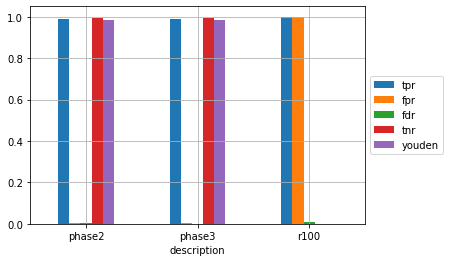

In [24]:
output_summary.groupby(['description']).mean().plot(kind='bar', grid=True, rot=0, yerr=output.groupby(['description']).std(), capsize=3).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Numbers for paper

In [25]:
output_all_chroms_summary.loc["phase3"].loc[eval_family_ids].apply([np.max, np.min]) * 100

,tpr,fpr,fdr,tnr,youden
amax,99.118676,0.447611,0.103523,99.837201,98.955877
amin,98.745205,0.162799,0.037092,99.552389,98.297594


In [26]:
output_all_chroms_summary.loc["r100"].loc[eval_family_ids].apply([np.max, np.min]) * 100

,tpr,fpr,fdr,tnr,youden
amax,100.0,100.0,1.104599,0.0,0.0
amin,100.0,100.0,0.748912,0.0,0.0


In [27]:
np.log2(output_all_chroms_summary.loc["r100"].loc[eval_family_ids].fdr) - \
np.log2(output_all_chroms_summary.loc["phase3"].loc[eval_family_ids].fdr)

cross_id
B5      3.715014
K6      4.335604
73-2    4.260688
45-1    3.754871
37-3    3.415497
Name: fdr, dtype: float64

In [28]:
output_all_chroms_summary.loc["phase2"].loc[eval_family_ids]

,tpr,fpr,fdr,tnr,youden
cross_id,,,,,
B5,0.989374,0.001811,0.000804,0.998189,0.987563
K6,0.989831,0.001344,0.000592,0.998656,0.988486
73-2,0.987726,0.002914,0.001263,0.997086,0.984812
45-1,0.988237,0.003613,0.001580,0.996387,0.984624
37-3,0.986060,0.004471,0.001992,0.995529,0.981588


## Check fraction accessible matches up

In [29]:
va = 0
vs = 0

for c in chrom_arms:

    a = load_phase3_accessibility(c)
    va += a.sum().compute()
    vs += a.shape[0]
    
va/vs

0.7257974394490119

In [30]:
va = 0
vs = 0

for c in chrom_arms:

    a = load_phase2_accessibility(c)
    va += a.sum().compute()
    vs += a.shape[0]
    
va/vs

0.6204559269110339

## Phase 2 vs phase 3

In [31]:
p2stats = output_all_chroms_summary.loc["phase2"].loc[eval_family_ids]
p2stats

,tpr,fpr,fdr,tnr,youden
cross_id,,,,,
B5,0.989374,0.001811,0.000804,0.998189,0.987563
K6,0.989831,0.001344,0.000592,0.998656,0.988486
73-2,0.987726,0.002914,0.001263,0.997086,0.984812
45-1,0.988237,0.003613,0.001580,0.996387,0.984624
37-3,0.986060,0.004471,0.001992,0.995529,0.981588


In [32]:
p3stats = output_all_chroms_summary.loc["phase3"].loc[eval_family_ids]
p3stats

,tpr,fpr,fdr,tnr,youden
cross_id,,,,,
B5,0.990844,0.002612,0.000604,0.997388,0.988233
K6,0.991187,0.001628,0.000371,0.998372,0.989559
73-2,0.988951,0.002232,0.000494,0.997768,0.986719
45-1,0.989310,0.003062,0.000689,0.996938,0.986247
37-3,0.987452,0.004476,0.001035,0.995524,0.982976


In [33]:
p2stats.fdr - p3stats.fdr

cross_id
B5      0.000199
K6      0.000221
73-2    0.000769
45-1    0.000891
37-3    0.000957
Name: fdr, dtype: float64